In [ ]:
# Setup and Data Download: Install Kaggle, upload Kaggle API key, set permissions, download the dataset.
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

Saving kaggle.json to kaggle.json
 92% 186M/202M [00:01<00:00, 153MB/s]
100% 202M/202M [00:01<00:00, 165MB/s]


In [ ]:
# Unzip Dataset: Unzip the downloaded dataset to access its contents.
! unzip cityscapes-image-pairs

In [ ]:
# Import Libraries and Setup: Import necessary libraries and setup paths for data processing.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image

import tensorflow as tf
from keras import layers, models

In [ ]:
# Load Image Data: Load paths for training and validation images.
image_train = Path('/content/cityscapes_data/train')
image_train = list(image_train.glob(r'**/*.jpg'))
image_train = pd.Series(image_train).astype(str)

image_val = Path('/content/cityscapes_data/val')
image_val = list(image_val.glob(r'**/*.jpg'))
image_val = pd.Series(image_val).astype(str)

In [ ]:
# Define Image and Mask Processing Functions: Define functions to process images and masks, and load them into numpy arrays.
def get_image(image_path):
  initial_img = Image.open(image_path)
  img = initial_img.crop((0, 0, 256, 256)).resize((128,128))
  img = np.array(img)/255.0
  return img

train_images = np.array([get_image(img) for img in image_train], dtype=np.float32)
val_images = np.array([get_image(img) for img in image_val], dtype=np.float32)

def get_mask(image_path):
  initial_img = Image.open(image_path)
  msk = initial_img.crop((256, 0, 512, 256)).resize((128,128))
  msk = np.array(msk)
  return msk

train_masks = np.array([get_mask(img) for img in image_train])
val_masks = np.array([get_mask(img) for img in image_val])

In [ ]:
# Define Classes and Labels: Define categories and labels for semantic segmentation.
labels = [
    (  'static'               ,  0 ,      [  0,  0,  0] ),
    (  'dynamic'              ,  1 ,      [111, 74,  0] ),
    (  'ground'               ,  2 ,      [ 81,  0, 81] ),
    (  'road'                 ,  3 ,      [128, 64,128] ),
    (  'sidewalk'             ,  4 ,      [244, 35,232] ),
    (  'parking'              ,  5 ,      [250,170,160] ),
    (  'rail track'           ,  6 ,      [230,150,140] ),
    (  'building'             ,  7 ,      [ 70, 70, 70] ),
    (  'wall'                 ,  8 ,      [102,102,156] ),
    (  'fence'                ,  9 ,      [190,153,153] ),
    (  'guard rail'           , 10 ,      [180,165,180] ),
    (  'bridge'               , 11 ,      [150,100,100] ),
    (  'tunnel'               , 12 ,      [150,120, 90] ),
    (  'pole'                 , 13 ,      [153,153,153] ),
    (  'traffic light'        , 14 ,      [250,170, 30] ),
    (  'traffic sign'         , 15 ,      [220,220,  0] ),
    (  'vegetation'           , 16 ,      [107,142, 35] ),
    (  'terrain'              , 17 ,      [152,251,152] ),
    (  'sky'                  , 18 ,      [ 70,130,180] ),
    (  'person'               , 19 ,      [220, 20, 60] ),
    (  'rider'                , 20 ,      [255,  0,  0] ),
    (  'car'                  , 21 ,      [  0,  0,142] ),
    (  'truck'                , 22 ,      [  0,  0, 70] ),
    (  'bus'                  , 23 ,      [  0, 60,100] ),
    (  'caravan'              , 24 ,      [  0,  0, 90] ),
    (  'trailer'              , 25 ,      [  0,  0,110] ),
    (  'train'                , 26 ,      [  0, 80,100] ),
    (  'motorcycle'           , 27 ,      [  0,  0,230] ),
    (  'bicycle'              , 28 ,      [119, 11, 32] ),
]

id_color = {label[1]:label[2] for label in labels}

In [ ]:
# Define U-Net Model Architecture: Implement U-Net model architecture.
def replace_with_similar_color(mask, id_to_color_dict):
  similar_matrix = np.full((mask.shape[0], mask.shape[1]), 500)
  closest_matrix = np.full((mask.shape[0], mask.shape[1]), None)

  for id, color in id_to_color_dict.items():
    distance = np.sqrt(np.linalg.norm(mask-color, axis=-1))
    is_closer = distance<similar_matrix
    similar_matrix = np.where(is_closer, distance, similar_matrix)
    closest_matrix = np.where(is_closer, id, closest_matrix)

  for row in range(closest_matrix.shape[0]):
    for col in range(closest_matrix.shape[1]):
      mask[row, col, :] = id_color[closest_matrix[row, col]]

  return closest_matrix

In [ ]:
# Compile and Train the U-Net Model: Setup and execute the training of the U-Net model, and save the best-performing model.
train_masks_id = []
for mask in tqdm(train_masks):
  train_masks_id.append(replace_with_similar_color(mask, id_color))
train_masks_id = np.stack(train_masks_id).astype('int8')

val_masks_id = []
for mask in tqdm(val_masks):
  val_masks_id.append(replace_with_similar_color(mask, id_color))
val_masks_id = np.stack(val_masks_id).astype('int8')

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

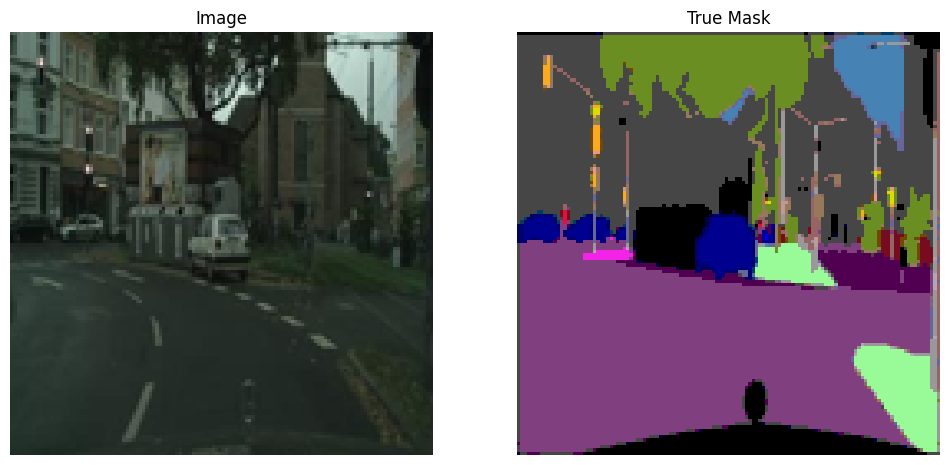

In [ ]:
# Load Best Model and Predict: Load the best model and use it to predict the segmentation on the validation dataset.
def display(display_list):
  plt.figure(figsize=(12, 12))
  title = ['Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i != 0:
      plt.imshow(display_list[i].astype("uint8"))
    else:
      plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

display([train_images[10], train_masks[10]])

In [ ]:
# Define Plot Function for Predictions: Define a function to plot predictions alongside actual images for comparison.
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, activation='relu'):
    # first layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)

    # second layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)

    return x

def get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True, activation='relu'):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, activation=activation)

    # Expansive Path
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9,  n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = tf.keras.layers.Conv2D(29, (1, 1))(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# Display Predictions: Display predictions for validation images to assess model performance.
check = tf.keras.callbacks.ModelCheckpoint('model-unet.hdf5', monitor= "val_accuracy", verbose = 1, save_best_only = True)
input_img = tf.keras.layers.Input((128, 128,3), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True, activation='relu')
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_masks_id, batch_size=64, epochs=40, validation_data=(val_images, val_masks_id), callbacks=[check])

Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 1.8574 - accuracy: 0.5761
Epoch 1: val_accuracy improved from -inf to 0.19927, saving model to model-unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 114s 2s/step - loss: 1.8574 - accuracy: 0.5761 - val_loss: 19.3806 - val_accuracy: 0.1993
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 1.0708 - accuracy: 0.7327
Epoch 2: val_accuracy improved from 0.19927 to 0.45318, saving model to model-unet.hdf5
47/47 [==============================] - 40s 853ms/step - loss: 1.0708 - accuracy: 0.7327 - val_loss: 2.1696 - val_accuracy: 0.4532
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.7586
Epoch 3: val_accuracy improved from 0.45318 to 0.56135, saving model to model-unet.hdf5
47/47 [==============================] - 39s 826ms/step - loss: 0.9438 - accuracy: 0.7586 - val_loss: 1.8895 - val_accuracy: 0.5614
Epoch 4/40
47/47 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.7731
Epoch 4: val_accuracy did not improve from 0.56135
47/47 [==============================] - 38s 816ms/step - loss: 0.8721 - accuracy: 0.7731 - val_

In [ ]:
# Define model training parameters and callbacks, then start training.
y_pred_id = best_model.predict(val_images)
y_pred_id = np.array(y_pred_id)
y_pred_id = np.argmax(y_pred_id, axis=-1)

In [ ]:
# Load the best-performing model, predict on validation data, and convert predictions to label IDs.
pred_show = np.zeros(shape=(pred_id[index].shape[0],pred_id[index].shape[0], 3))
  for row in range(pred_id[index].shape[0]):
      for col in range(pred_id[index].shape[1]):
        pred_show[row, col, :] = id_color[pred_id[index][row, col]]
  display([val_images[index], val_masks[index], pred_show])

In [ ]:
# Define a function to display prediction results alongside actual images for comparison.
plot_prediction(y_pred_id, i)

Output hidden; open in https://colab.research.google.com to view.